In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools

In [2]:
# set results path
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev'

In [3]:
# prepare roi data
data_t1wT2wRatio = pd.read_csv(os.path.join(results_dir, 't1wT2wRatio', 't1wT2wRatio_cb_anat_fsl.csv'))
data_falff = pd.read_csv(os.path.join(results_dir, 'fALFF', 'fALFF_cb_anat_cifti.csv'))
dem_herit = pd.read_csv(os.path.join(results_dir,'sub_heritabitily.csv'), dtype=np.str)

atlas_dir = os.path.join(os.getcwd(), 'atlas')
atlas = cb_tools.atlas_load('cb_anat_fsl', atlas_dir)

num_str_col = 6
palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=9)

In [4]:
def hemi_merging(x, num_str_col):
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: x.split('_')[0], inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: x.split('_')[0], inplace=True)

    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0),x.iloc[:,-num_str_col:]], axis=1)
    
    return x_merged

data_t1wT2wRatio = hemi_merging(data_t1wT2wRatio, num_str_col)
data_falff = hemi_merging(data_falff, num_str_col)
lobues_name = atlas.label_info['lobule'][:18:2]

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
def twins_select(data_herit, dem_herit, num_str_col):
    twins_in = np.c_[np.isin(dem_herit['twin1'].values, data_herit['Sub'].values),
                     np.isin(dem_herit['twin2'].values, data_herit['Sub'].values)]
    
    dem_herit = dem_herit.loc[twins_in.sum(-1) == 2]
    
    data_herit = data_herit.set_index('Sub',drop=False)

    col = data_herit.columns[:-num_str_col]
    # MZ
    mz1 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='MZ','twin1'],col]
    mz2 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='MZ','twin2'],col]
    mz = np.stack((mz1.values, mz2.values))
    
    # DZ
    dz1 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='DZ','twin1'],col]
    dz2 = data_herit.loc[dem_herit.loc[dem_herit['zygosity']=='DZ','twin2'],col]
    dz = np.stack((dz1.values, dz2.values))
    
    return mz, dz

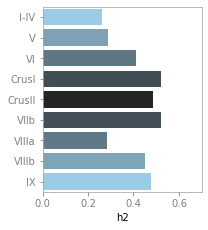

In [9]:
#%% fig 1j
# calculate h2 - lobule-wise
mz_anat, dz_anat = twins_select(data_t1wT2wRatio, dem_herit, num_str_col)
mz_func, dz_func = twins_select(data_falff, dem_herit, num_str_col)

h2_anat, perct_anat = cb_tools.heritability(mz_anat, dz_anat, n_permutation=10000)
h2_anat_df = pd.DataFrame(h2_anat[None,...], columns=atlas.label_info['lobule'][:18:2].values)
h2_anat_df = h2_anat_df.stack().reset_index(-1, name='h2')

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3.3))

sns.barplot(x='h2', y='level_1', ci=None, palette=palette_cb, data=h2_anat_df, ax=ax)
ax.set_xlim([0,0.7])
ax.set_ylabel(None)
ax.tick_params(colors='gray', which='both')

[ax.spines[k].set_color('darkgray') for k in ['top','bottom','left','right']]
plt.tight_layout()
